LOAD IN DATA (CNN)

In [1]:
#imports
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import skimage.io
import datetime
import random
from scipy.signal import spectrogram

#PyTorch stuff
import torch
import torchvision as torchv
import torch.nn as nn 
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.datasets import ImageFolder

# File paths
TESTDIR = './../Data/Hyundai/'
TESTPATH = 'Lock/'
TESTSIG = 'keyfob_signal2023Y1022163258.raw'
TESTOUT = './../Data/MelSpec/Hyundai/'

IMG_SIZE=224
IMG_L = 336

In [ ]:
# ROCm 5.5 MIOpen workaround
if not torch.cuda.is_available():
    raise Exception("CUDA/ROCm not working!")
else:
    print('CUDA/ROCm installed!')

# activate

if not torch.cuda.is_initialized():
    torch.cuda.init()
else:
    print('CUDA/ROCm initialized!')

midevices = torch.cuda.device_count()
print('CUDA/ROCm devices:', midevices)

for i in range(midevices):
    print(f'{i} CUDA/ROCm device:', torch.cuda.get_device_name(i))

# set device
torch.cuda.set_device(0)
print('CUDA/ROCm device set to:', torch.cuda.current_device())

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
classes = ('Lock', 'Unlock')

In [4]:
# Define the directory where Mel spectrogram images are stored
data_directory = TESTOUT

# Define data transformations
transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_L)),
                                transforms.ToTensor()])

# Define the dataset using ImageFolder
dataset = ImageFolder(data_directory, transform=transform)

# Split the dataset into train and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for training and validation
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [5]:
data_iterator = iter(train_loader)
images, labels = next(data_iterator)

print(images.shape)
print(images[1].shape)
print(labels[1].item())

torch.Size([5, 3, 224, 336])
torch.Size([3, 224, 336])
0


In [6]:

def showimg(img):    
    # Convert the image tensor back to a NumPy array
    npimg = img.numpy()
    # Display the image using matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

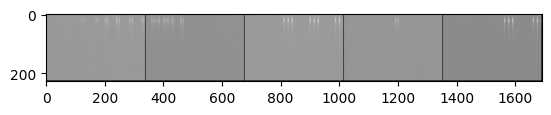

Lock Lock Unlock Lock Unlock


In [7]:
showimg(torchv.utils.make_grid(images))
print(' '.join(classes[labels[j]] for j in range(5)))

# CNN in PyTorch

In [8]:
class FirstCNN(nn.Module):
    def __init__(self):
        super(FirstCNN, self).__init__()

        # Single conv layer
        self.conv1 = nn.Conv2d(3,32,3,padding=(1,1), stride=(2,2))

    def forward(self, x):
        # execute forward pass
        x = self.conv1(x)
        return(x)


# Create object of class
net = FirstCNN()
net.to(device)
print(net)

FirstCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)


In [9]:
# output from the conv layer
out = net(images.to(device))
out.shape

torch.Size([5, 32, 112, 168])

In [10]:
# total parameters in a network
for param in net.parameters():
    print(param.shape, "Parameters")

torch.Size([32, 3, 3, 3]) Parameters
torch.Size([32]) Parameters


In [11]:
out1 = out[0,0,:,:].to('cpu').detach().numpy()
print(out1.shape)

(112, 168)


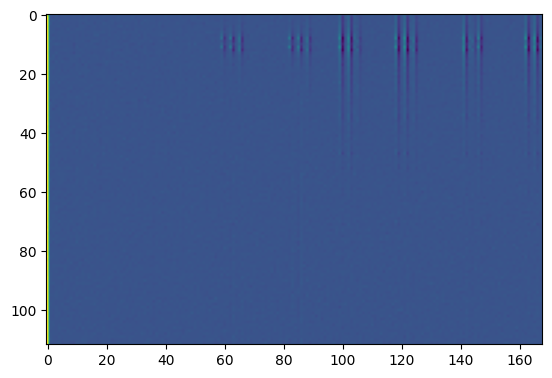

<Figure size 20000x20000 with 0 Axes>

In [12]:
plt.imshow(out[0,0,:,:].to('cpu').detach().numpy())
plt.figure(figsize=(10,10),dpi=2000)
plt.show()

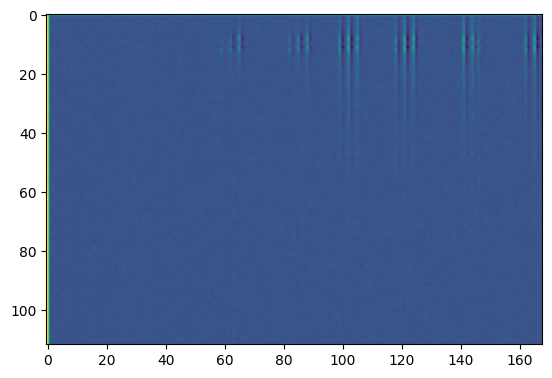

<Figure size 20000x20000 with 0 Axes>

In [13]:
plt.imshow(out[0,1,:,:].to('cpu').detach().numpy())
plt.figure(figsize=(10,10),dpi=2000)
plt.show()

In [14]:
class FirstCNN_V2(nn.Module):
    def __init__(self):
        super(FirstCNN_V2, self).__init__()

        # sequential similar to keras
        self.model = nn.Sequential(
            nn.Conv2d(3,3,3, padding=(1,1), stride=(2,2)),
            nn.Conv2d(3,64,3)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [15]:
net = FirstCNN_V2()
net.to(device)

out = net(images.to(device))
out.shape

torch.Size([5, 64, 110, 166])

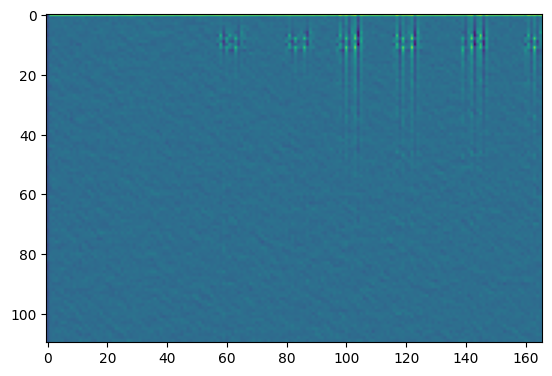

In [16]:

plt.imshow(out[0,0,:,:].to('cpu').detach().numpy())

In [17]:
class FirstCNN_V3(nn.Module):
    def __init__(self):
        super(FirstCNN_V3, self).__init__()

        # sequential similar to keras
        self.model = nn.Sequential(
            nn.Conv2d(3,3,5),
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Conv2d(3,64,3),
            nn.AvgPool2d(2,stride=2)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [18]:
net = FirstCNN_V3()
net.to(device)
out = net(images.to(device))
out.shape

torch.Size([5, 64, 54, 82])

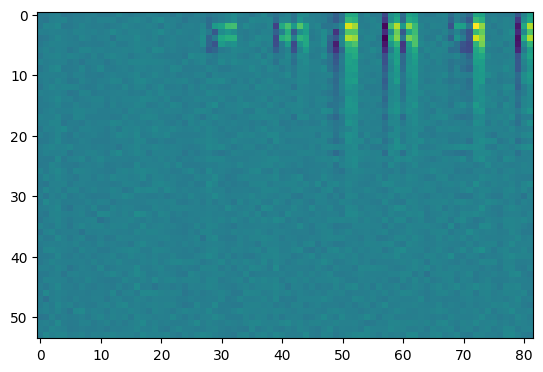

In [19]:
plt.imshow(out[0,0,:,:].to('cpu').detach().numpy())

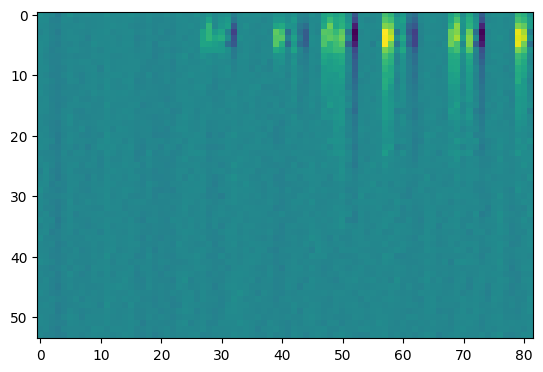

In [20]:
plt.imshow(out[0,1,:,:].to('cpu').detach().numpy())

# RNN in PyTorch

In [ ]:
from torch.utils.data import DataLoader, Dataset

class RFSignalDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        sample = {'data': data, 'label': self.labels[index]}
        return sample

# Define a custom neural network model
class RFSignalClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(RFSignalClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
# Create datasets and data loaders
train_dataset = RFSignalDataset(X_train, y_train)
test_dataset = RFSignalDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Initialize the model and optimizer
input_size = (22766528)  # Specify the input size based on your X_train shape
num_classes = 3 # Specify the number of classes
model = RFSignalClassifier(input_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # For classification tasks

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        data = batch['data']
        labels = batch['label']
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop (optional)
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for batch in test_loader:
            data = batch['data']
            labels = batch['label']
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')